# Australian Weather Forecasting - Imputing Data

## Import libraries

In [1]:
#import sys
#sys.path.append('/home/ga7er/.local/bin')
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import itertools
import matplotlib.pyplot as plt
import scipy.stats as scistat
import arviz as az
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import scipy as sp
import multiprocessing
n_cpu = multiprocessing.cpu_count()

## Loading Data

In [2]:
aussy_Rain = pd.read_csv('../data/weather_imputed.csv',index_col=0)
aussy_Rain

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
102650,-0.180348,-1.309144,0.081969,-0.086053,0.288592,-0.061313,1.055339,0.695985,0.303918,0.318322,-0.519303,-0.616942,0.412018,2016-08-01,Nuriootpa,SW,WNW,SW,Yes,Yes
36352,-0.050506,-0.709748,0.763817,-0.324154,-0.265060,-0.061313,1.098615,1.004636,0.278563,0.279572,-0.424327,-0.499517,0.524478,2010-05-29,WaggaWagga,NNW,NE,N,Yes,Yes
128486,-0.730269,-0.862535,-0.196533,-0.472967,0.150179,-0.061313,-0.329473,-0.024200,0.329274,0.328702,-0.786965,-0.479946,-0.285231,2013-09-15,Hobart,NW,NNW,ESE,No,No
62024,-0.967041,-1.273885,-0.090894,-0.770593,-1.026331,-0.170837,1.271716,0.284451,0.358103,0.363300,-1.106433,-0.553337,-0.262739,2015-07-08,Sale,E,SE,E,Yes,No
137911,0.942407,1.100190,-0.014066,0.181810,-0.403473,0.431547,0.492759,1.244698,0.295582,0.299639,0.983058,-0.024926,0.951824,2014-03-11,Darwin,SE,SW,ESE,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50208,0.400124,0.465536,-0.196533,-0.056291,-1.026331,-0.061313,-0.372748,0.353040,0.313991,0.320398,0.266414,-0.083638,-0.285231,2015-12-08,Tuggeranong,WNW,SE,WNW,No,No
7155,-0.692080,-1.144604,-0.186929,-0.443205,-0.126647,-0.170837,0.362933,-0.264262,0.300792,0.300331,-0.890577,-0.514195,-0.262739,2012-06-04,Cobar,SW,WSW,W,No,No
117412,-0.386568,-0.086847,-0.196533,-0.324154,-0.541886,0.322022,-0.242922,-0.538619,0.331705,0.326972,-0.346618,-0.108102,-0.285231,2016-09-04,PerthAirport,WSW,NE,SW,No,No
142098,0.789652,1.946395,-0.196533,-0.264629,0.496211,-0.389885,-1.584458,-1.293098,0.300445,0.296179,0.922618,0.694299,-0.285231,2017-03-22,Uluru,ENE,E,WNW,No,No


## Preprocessing 

### Convert our Date column into datetime object

In [3]:
aussy_Rain['Date']=pd.to_datetime(aussy_Rain['Date'])

### Convert Date into Season 
Thanks to https://stackoverflow.com/questions/44124436/python-datetime-to-season 

In [4]:
[(month%12 + 3)//3 for month in range(1, 13)]

[1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

Where, in Australia: http://www.bom.gov.au/climate/glossary/seasons.shtml  
* Month 1 = Summer
* Month 2 = Autumn
* Month 3 = Winter
* Month 4 = Spring

In [5]:
aussy_Rain['Date'] = (aussy_Rain.Date.dt.month%12 + 3)//3

In [6]:
aussy_Rain['Date']

102650    3
36352     2
128486    4
62024     3
137911    2
         ..
50208     1
7155      3
117412    4
142098    2
111940    1
Name: Date, Length: 3000, dtype: int64

In [7]:
num_locations = aussy_Rain.groupby('Location').apply(len)

### Dummy encoding for other Categoricals

In [8]:
encoding = dict()
for column in aussy_Rain:
    if aussy_Rain[column].dtype == object:
        unique = aussy_Rain[column].unique()
        encoding[column] = {name: index for index, name in enumerate(unique)}
aussy_Rain = aussy_Rain.replace(encoding)
location_ID = encoding["Location"]

Remove RISK_MM (kaggle dataset authors say this variable should be removed)

In [9]:
aussy_Rain = aussy_Rain.drop(['RISK_MM'], axis=1)

## Preliminary Visualization

### Visualize model with priors

In [10]:
#### Posterior Distribution of parameters# Use pm.find_MAP() to find the maximum a-posteriori (MAP) estimate for the vector of regression coefficients .
with pm.Model() as manual_logistic_model:
    Y = aussy_Rain["RainTomorrow"]
    α = pm.Normal('α', mu=0, sd=100) 
    β1 = pm.Normal('β1', mu=0, sd=100) 
    β2 = pm.Normal('β2', mu=0, sd=100) 
    β3 = pm.Normal('β3', mu=0, sd=100) 
    β4 = pm.Normal('β4', mu=0, sd=100)
    β5 = pm.Normal('β5', mu=0, sd=100) 
    β6 = pm.Normal('β6', mu=0, sd=100)
    β7 = pm.Normal('β7', mu=0, sd=100) 
    β8 = pm.Normal('β8', mu=0, sd=100)
    β9 = pm.Normal('β9', mu=0, sd=100)
    β10 = pm.Normal('β10', mu=0, sd=100)
    β11 = pm.Normal('β11', mu=0, sd=100)
    β12 = pm.Normal('β12', mu=0, sd=100)
    β13 = pm.Normal('β13', mu=0, sd=100)
    β14 = pm.Normal('β14', mu=0, sd=100)
    β15 = pm.Normal('β15', mu=0, sd=100)
    β16 = pm.Normal('β16', mu= 0, sd=100)
    β17 = pm.Normal('β17', mu=0, sd=100)


    μ = α + pm.math.dot(aussy_Rain["MinTemp"], β1) + pm.math.dot(aussy_Rain["MaxTemp"],β2) + pm.math.dot(aussy_Rain["Rainfall"], β3) + pm.math.dot(aussy_Rain["WindGustSpeed"],β4) + pm.math.dot(aussy_Rain["WindSpeed9am"], β5) + pm.math.dot(aussy_Rain["WindSpeed3pm"],β6) + pm.math.dot(aussy_Rain["Humidity9am"], β7) + pm.math.dot(aussy_Rain["Humidity3pm"],β8) + pm.math.dot(aussy_Rain["Pressure9am"], β9) + pm.math.dot(aussy_Rain["Pressure3pm"], β10) + pm.math.dot(aussy_Rain["Pressure9am"], β11) + pm.math.dot(aussy_Rain["Location"], β12) + pm.math.dot(aussy_Rain["WindGustDir"],β13) + pm.math.dot(aussy_Rain["WindDir9am"],β14) + pm.math.dot(aussy_Rain["WindDir3pm"],β15) + pm.math.dot(aussy_Rain["RainToday"],β16) + pm.math.dot(aussy_Rain["Date"], β17) 
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
    map_estimate = pm.find_MAP()
    #print(map_estimate)

logp = -1,435.6, ||grad|| = 2.4432: 100%|████| 219/219 [00:02<00:00, 86.89it/s]


### MAP ESTIMATE FOR Parameters (Logistic)

In [11]:
map_estimate

{'α': array(0.65699409),
 'β1': array(-0.14101429),
 'β2': array(0.17522064),
 'β3': array(-0.04815139),
 'β4': array(-0.21246961),
 'β5': array(-0.187702),
 'β6': array(0.18020366),
 'β7': array(-0.01003135),
 'β8': array(-0.65794988),
 'β9': array(-0.1251021),
 'β10': array(0.19079524),
 'β11': array(-0.1251021),
 'β12': array(0.00234566),
 'β13': array(-0.02843438),
 'β14': array(0.01734186),
 'β15': array(-0.01633591),
 'β16': array(1.13438992),
 'β17': array(0.02907664),
 'θ': array([0.50139213, 0.48881299, 0.86757012, ..., 0.89609875, 0.93094682,
        0.94295411])}

## Building Models

### Logistic Regression (full model)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 11 jobs)
NUTS: [Date, RainToday, WindDir3pm, WindDir9am, WindGustDir, Location, Temp3pm, Temp9am, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MaxTemp, MinTemp, Intercept]
Sampling 2 chains, 0 divergences: 100%|█| 6000/6000 [03:54<00:00, 25.57draws/s]


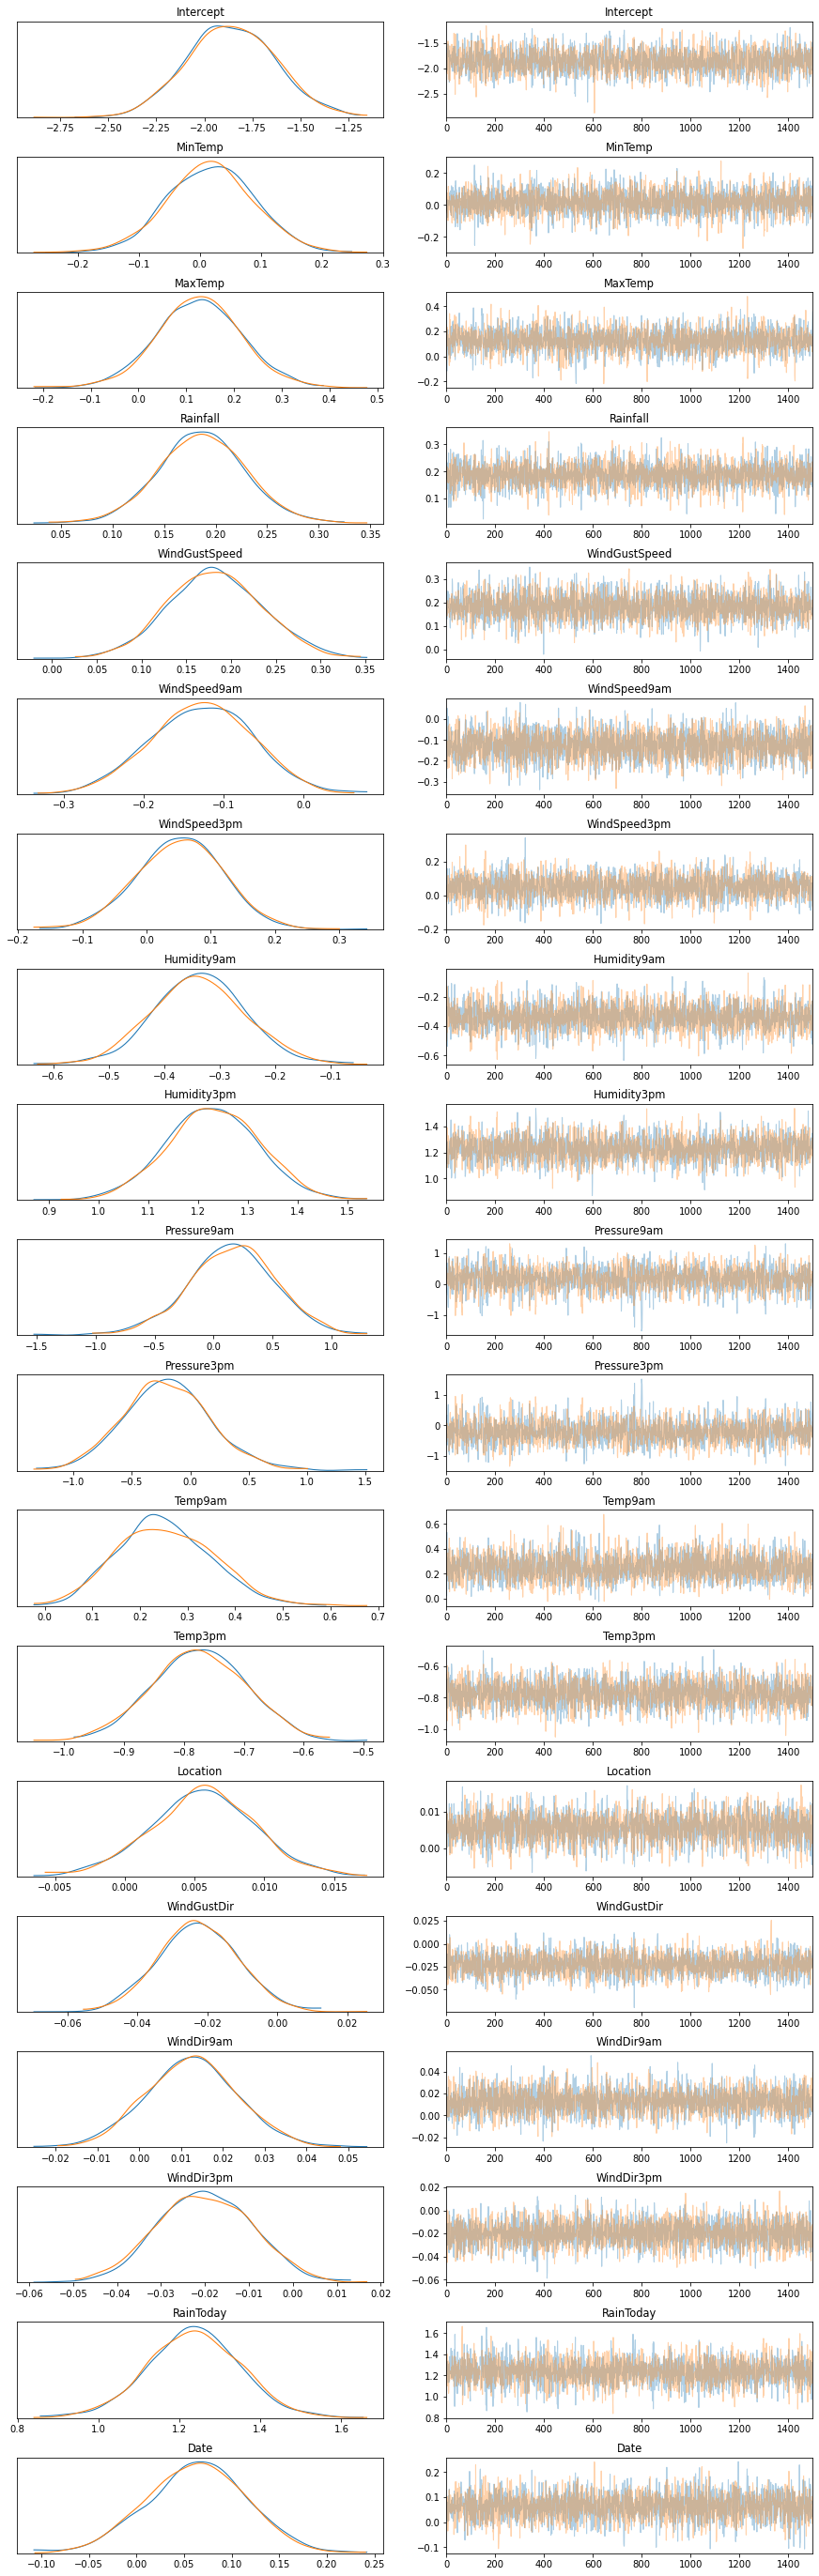

In [51]:
with pm.Model() as logistic_model:
    Y = aussy_Rain['RainTomorrow']
    pm.glm.GLM.from_formula('Y ~ MinTemp + MaxTemp + Rainfall + WindGustSpeed + WindSpeed9am + WindSpeed3pm + \
    Humidity9am + Humidity3pm + Pressure9am + Pressure3pm + Temp9am + Temp3pm + Location + WindGustDir +\
    WindDir9am + WindDir3pm + RainToday + Date', aussy_Rain, family=pm.glm.families.Binomial())
    full_trace = pm.sample(1500, tune=1500, chains = 2,cores = n_cpu-1,init='adapt_diag',target_accept = 0.95,model=logistic_model)
with logistic_model:
    pm.traceplot(full_trace)

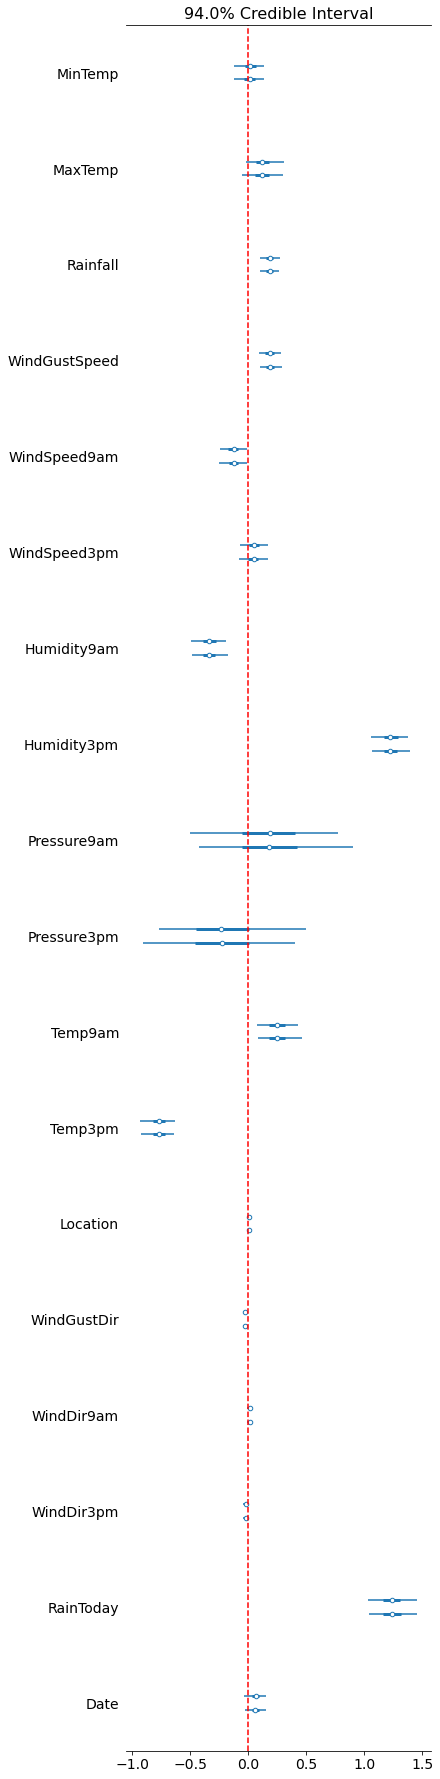

In [29]:
with logistic_model:
    az.plot_forest(full_trace, var_names="~Intercept")
plt.axvline(0,color='r',linestyle='dashed')
plt.show()

### Partial Logistic Regression Model

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 11 jobs)
NUTS: [RainToday, Temp3pm, Temp9am, Humidity3pm, Humidity9am, WindGustSpeed, Rainfall, Intercept]
Sampling 2 chains, 0 divergences: 100%|█| 6000/6000 [00:53<00:00, 111.64draws/s


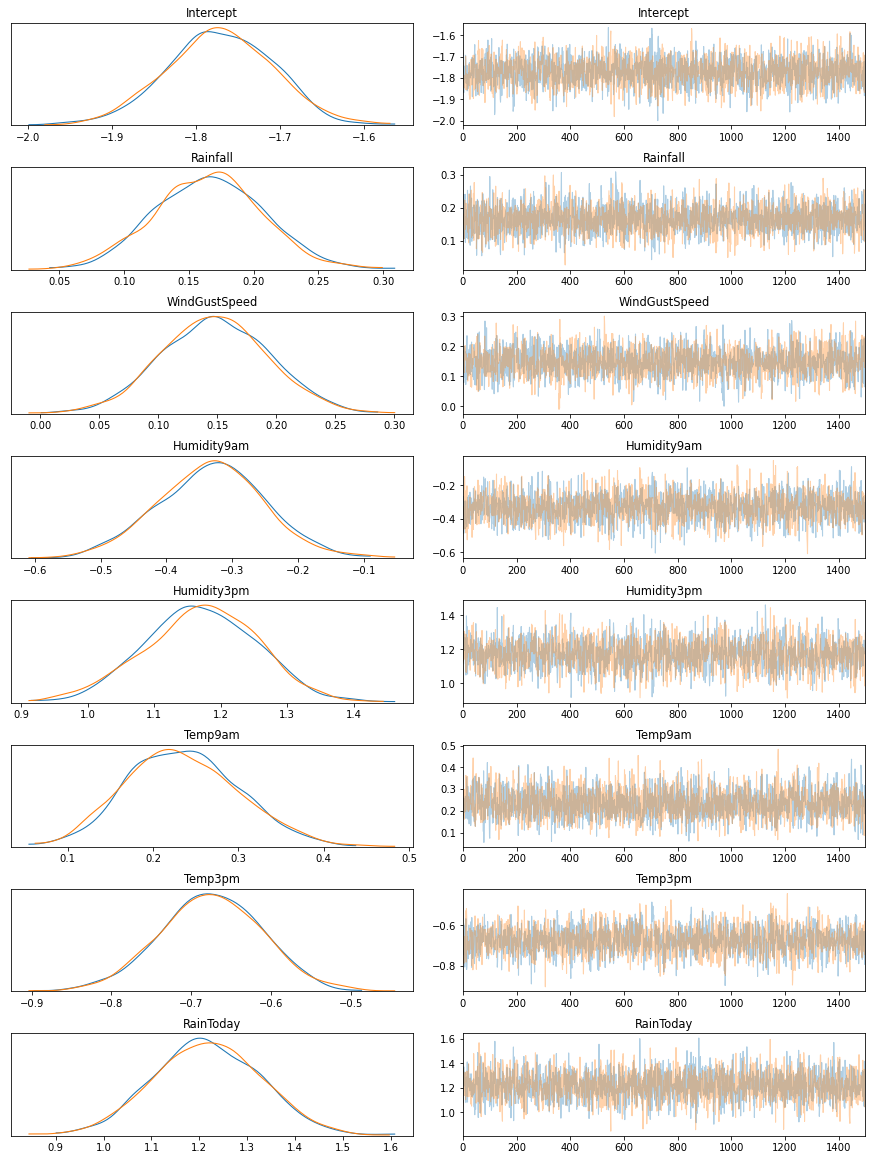

In [40]:
with pm.Model() as partial_logistic_model:
    Y = aussy_Rain['RainTomorrow']
    pm.glm.GLM.from_formula('Y ~ Rainfall + WindGustSpeed + Humidity9am + Humidity3pm  + Temp9am + Temp3pm + RainToday', aussy_Rain, family=pm.glm.families.Binomial())
    partial_trace = pm.sample(1500, tune=1500, chains=2,cores=n_cpu-1, init='adapt_diag',target_accept=0.95)
with partial_logistic_model:
    pm.traceplot(partial_trace)

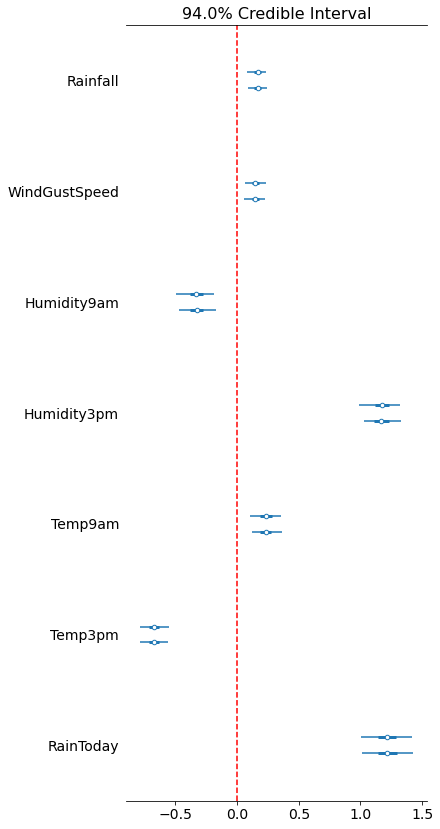

In [54]:
with partial_logistic_model:
    az.plot_forest(partial_trace, var_names="~Intercept")
plt.axvline(0,color='r',linestyle='dashed')
plt.show()

### Unpooled Model

In [31]:
Local = aussy_Rain.Location.unique()
locations = len(Local)
location_names = list(location_ID.keys())
Location_lookup = dict(zip(Local, range(len(Local))))
location_Code = aussy_Rain['Location'] = aussy_Rain.Location.replace(Location_lookup).values 
print(aussy_Rain['Location'])

109407     0
85423      1
125335     2
5681       3
65032      4
          ..
100426     7
60569     20
6762       8
88531     16
37514     33
Name: Location, Length: 3000, dtype: int64


In [32]:
Rainfall = aussy_Rain['Rainfall']
RainTomorrow =aussy_Rain['RainTomorrow']

In [33]:
with pm.Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=100, shape=locations)
    beta1 = pm.Normal('beta1', 0, sd=100)
    mu = beta0[location_Code] + beta1*Rainfall
    θ = pm.Deterministic('θ',  pm.invlogit(mu))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=RainTomorrow) 

In [20]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, chains=4,cores = n_cpu-1, tune=1000)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 11 jobs)
NUTS: [beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:32<00:00, 247.28draws/s


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],-1.06,0.29,-1.58,-0.52,0.0,0.0,9165.01,7018.33,9302.95,2447.44,1.0
beta0[1],-1.08,0.33,-1.69,-0.49,0.0,0.0,7836.81,4888.32,8372.68,2531.10,1.0
beta0[2],-0.55,0.26,-1.01,-0.05,0.0,0.0,10051.84,6662.75,10130.21,3047.50,1.0
beta0[3],-1.60,0.37,-2.33,-0.94,0.0,0.0,9670.63,8478.83,9617.59,2634.78,1.0
beta0[4],-1.34,0.28,-1.85,-0.81,0.0,0.0,7044.02,5962.20,7208.01,2694.30,1.0
...,...,...,...,...,...,...,...,...,...,...,...
θ[2995],0.12,0.04,0.05,0.21,0.0,0.0,7189.52,5745.13,7612.68,2711.46,1.0
θ[2996],0.16,0.04,0.09,0.24,0.0,0.0,9500.20,6965.30,10247.30,2860.51,1.0
θ[2997],0.18,0.05,0.11,0.28,0.0,0.0,10623.66,8147.88,10773.66,2716.53,1.0
θ[2998],0.25,0.05,0.16,0.35,0.0,0.0,8267.69,7494.15,8252.47,3021.34,1.0


In [21]:
estimate_unpool = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=Location_lookup)
se_unpool = pd.Series(unpooled_trace['beta0'].std(axis=0), index=Location_lookup)

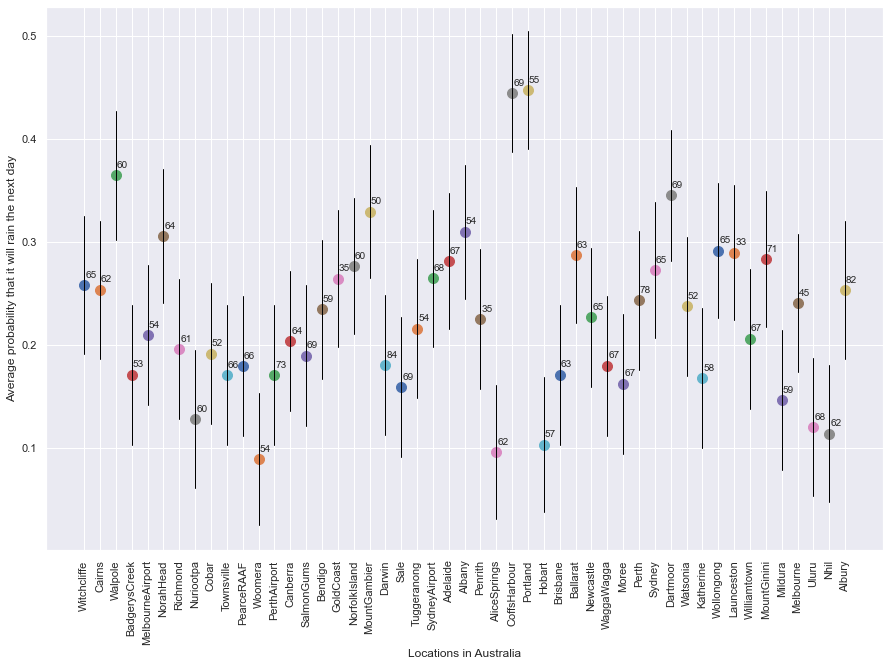

In [26]:
sns.set()

def sigmoid(x):
    return (1 / (1+ np.exp(-x)))

m_list = list()
stdev_list = list()
beta0 = np.mean(unpooled_trace['beta0'], axis=0)
beta1 = np.mean(unpooled_trace['beta1'], axis=0)
fig_unpooled = plt.figure(figsize = (15,10))
for num,beta0i in enumerate(beta0):
    m = np.mean(sigmoid(beta0i + beta1*Rainfall),axis=0); m_list.append(m)
    stdev = np.std(sigmoid(beta0i+beta1*Rainfall),axis=0); stdev_list.append(stdev)
    plt.scatter(location_names[num], m,s=100)
    plt.plot([location_names[num],location_names[num]],[m+stdev,m-stdev],'black',linewidth=1)
plt.xticks(rotation=90)
for i, txt in enumerate(num_locations):
    plt.annotate(txt, (location_names[i],m_list[i]),xytext=(1, 8),textcoords="offset points",fontsize=10)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');
plt.show();

The numbers on each bar indicate the number of samples for each location.

### Hierachical Model 

In [56]:
with pm.Model() as intercept_model:
    #Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100)
    sigma_b = pm.Exponential("sigma_b", .5)

    #Intercept, Random
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=locations)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=locations)
    #Error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    #E(X)
    y_hat = a[location_Code] + b[location_Code] * Rainfall
    #Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=RainTomorrow)

In [58]:
with intercept_model:
    intercept_model_trace = pm.sample(3500, step = pm.NUTS(target_accept = 0.999), chains=4,cores = n_cpu-1, tune=1000)
    intercept_model_idata = az.from_pymc3(intercept_model_trace)
az.summary(intercept_model_idata, round_to=2)

Multiprocess sampling (4 chains in 11 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains, 0 divergences: 100%|█| 18000/18000 [03:14<00:00, 92.76draws/
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.26,0.01,0.23,0.28,0.0,0.0,7398.75,7398.75,7404.15,9033.33,1.0
mu_b,0.25,0.04,0.18,0.33,0.0,0.0,5802.57,5734.20,5849.56,8195.14,1.0
a[0],0.26,0.04,0.19,0.33,0.0,0.0,20870.76,19972.04,20933.77,9081.93,1.0
a[1],0.25,0.04,0.18,0.33,0.0,0.0,19226.16,18685.35,19224.68,9428.41,1.0
a[2],0.33,0.04,0.26,0.41,0.0,0.0,10321.66,10113.14,10399.27,9883.19,1.0
...,...,...,...,...,...,...,...,...,...,...,...
b[47],0.39,0.20,0.00,0.77,0.0,0.0,10369.21,8597.95,10541.27,8579.22,1.0
b[48],0.02,0.03,-0.04,0.09,0.0,0.0,20382.62,9050.92,20372.69,10229.83,1.0
sigma_a,0.06,0.01,0.04,0.08,0.0,0.0,3005.51,3005.51,2960.18,3969.68,1.0
sigma_b,0.22,0.04,0.15,0.28,0.0,0.0,4371.16,4371.16,4288.88,7258.62,1.0


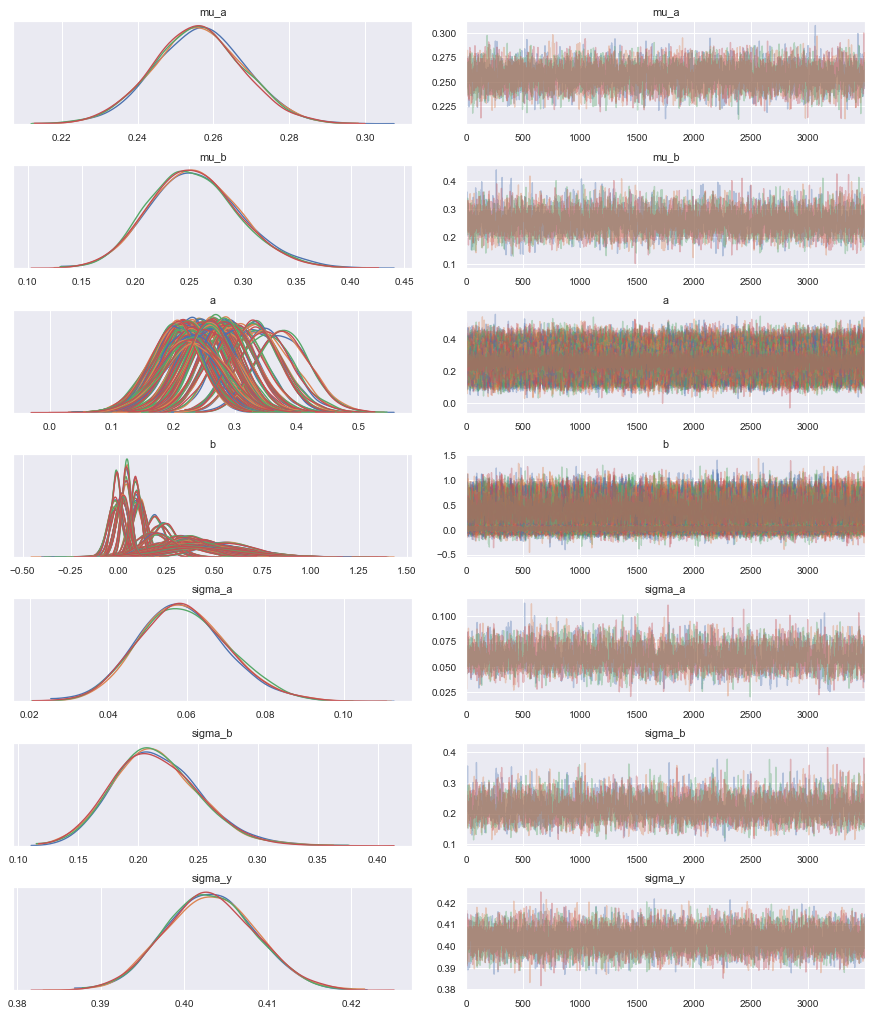

In [29]:
with intercept_model:
    pm.traceplot(intercept_model_trace)

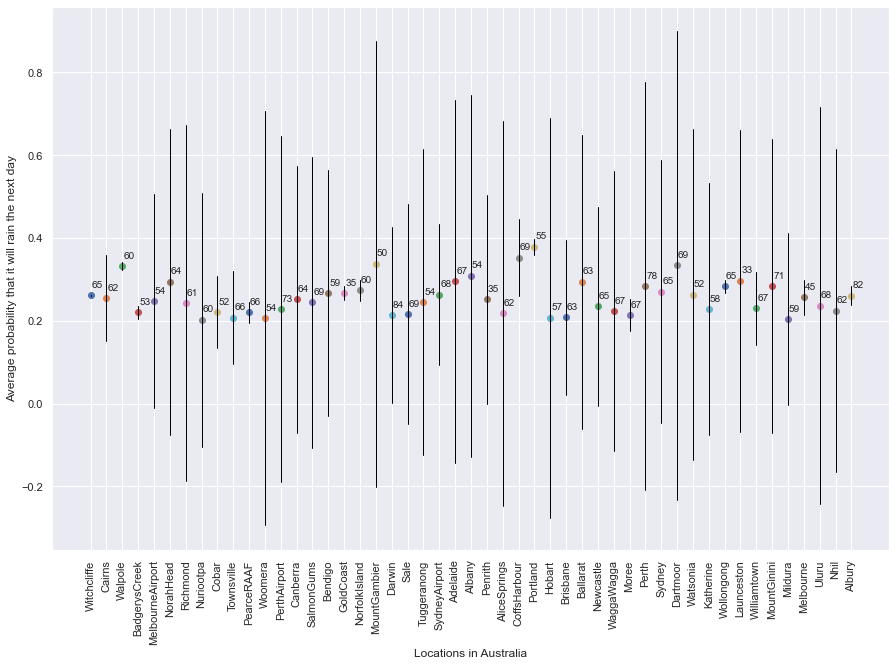

In [30]:
sns.set()
m_list = list()
stdev_list = list()
a = np.mean(intercept_model_trace['a'], axis=0)
b = np.mean(intercept_model_trace['b'], axis=0)
fig_hierarchical = plt.figure(figsize = (15,10))
for num,(ai,bi) in enumerate(zip(a,b)):
    m = np.mean(ai+bi*Rainfall,axis=0)
    m_list.append(m)
    stdev = np.std(ai+bi*Rainfall,axis=0)
    stdev_list.append(stdev)
    plt.scatter(Location_lookup[num], m)
    plt.plot([location_names[num],location_names[num]],[m+stdev,m-stdev],'black',linewidth=1)
plt.xticks(rotation=90)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');
for i, txt in enumerate(num_locations):
    plt.annotate(txt, (location_names[i],m_list[i]),xytext=(1, 8),textcoords="offset points",fontsize=10)
plt.ylabel('Average probability that it will rain the next day');plt.xlabel('Locations in Australia');
plt.show();

In [31]:
intercept_model_trace['a']

array([[0.2467505 , 0.29171245, 0.38026839, ..., 0.22810848, 0.23074744,
        0.19444603],
       [0.29139215, 0.29254831, 0.32708811, ..., 0.2827268 , 0.2416786 ,
        0.26574178],
       [0.20096839, 0.17785986, 0.3569264 , ..., 0.18831576, 0.2392077 ,
        0.28729947],
       ...,
       [0.27805344, 0.27221036, 0.37622415, ..., 0.09656425, 0.17123228,
        0.26998714],
       [0.28612942, 0.23409389, 0.31378124, ..., 0.3269258 , 0.23984249,
        0.25624126],
       [0.20047443, 0.20393636, 0.30279526, ..., 0.20168624, 0.26615322,
        0.27235036]])

In [61]:
aussy_Rain.Rainfall.min()

-0.2081209456683668

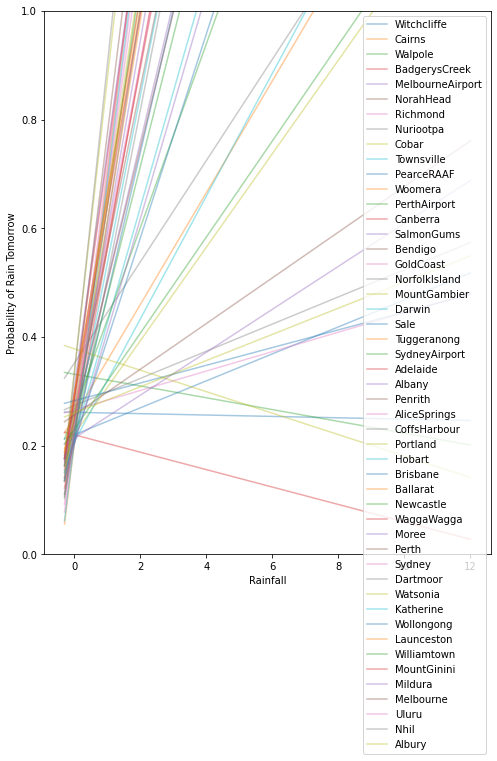

In [69]:
#plot hierarchical model
xvals = np.linspace(-.3,12)
b = intercept_model_trace['a'].mean(axis=0)
m = intercept_model_trace['b'].mean(axis=0)
plt.figure(figsize = (8,10))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, '-', alpha=0.4)
plt.ylim(0, 1)
plt.xlabel("Rainfall")
plt.ylabel("Probability of Rain Tomorrow")
plt.legend(location_names);

These are cities with negative correlation between rainfall and probability of rain tomorrow:

In [82]:
reverse_encoding = {value: key for key,value in encoding["Location"].items()}
for ix, mi in enumerate(m):
    if mi < 0:
        print(reverse_encoding[ix])

Witchcliffe
Walpole
BadgerysCreek
Portland


### Variational Approximation

In [32]:
SEED = 12345 
np.random.seed(SEED)

In [33]:
with intercept_model:
    approx = pm.fit(50000, method = 'advi', random_seed = SEED)

Average Loss = 1,633.1: 100%|██████████| 50000/50000 [00:39<00:00, 1262.73it/s]
Finished [100%]: Average Loss = 1,633.1


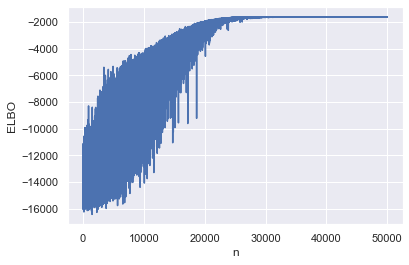

In [34]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)


In [35]:
PPC_SAMPLES = 4000
advi_trace = approx.sample(PPC_SAMPLES)

<MultiTrace: 1 chains, 4000 iterations, 10 variables>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016D4AFDB6A0>,
      dtype=object)

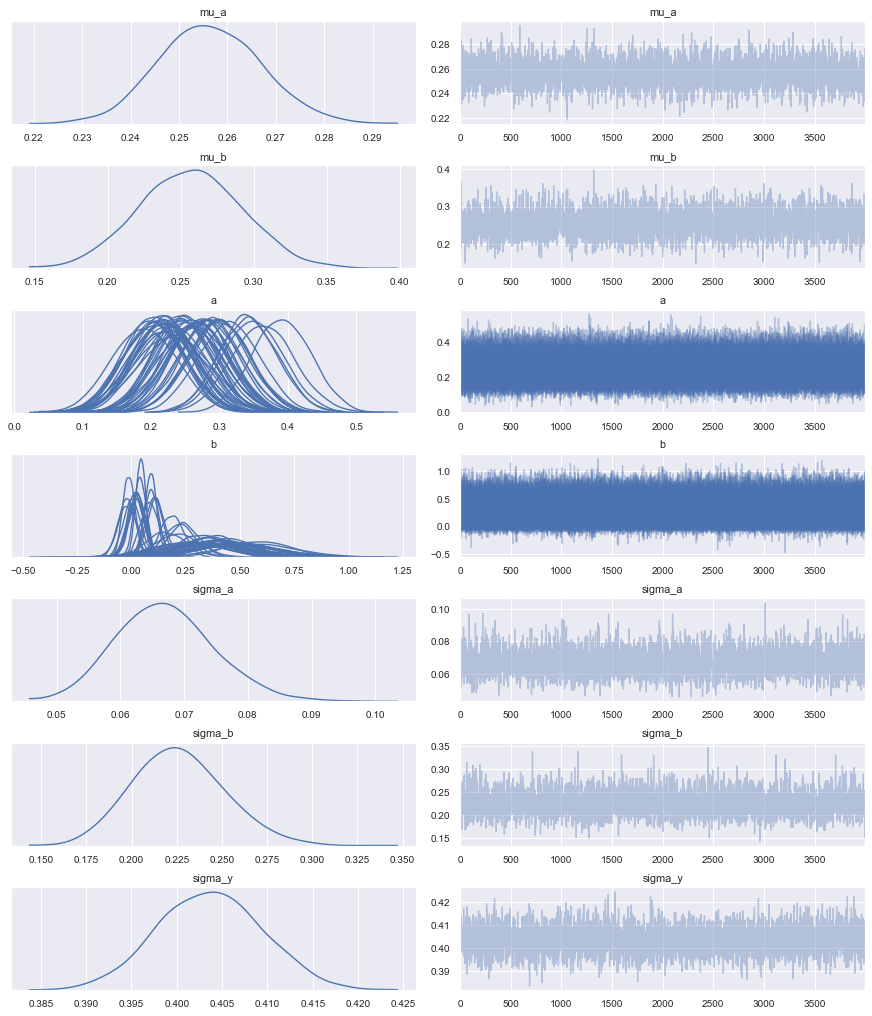

In [36]:
pm.traceplot(advi_trace);

In [37]:
pm.summary(advi_trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.256,0.010,0.238,0.277,0.000,0.000,4003.0,4003.0,3994.0,3802.0,NaN
mu_b,0.256,0.035,0.192,0.320,0.001,0.000,3727.0,3725.0,3730.0,3675.0,NaN
a[0],0.264,0.044,0.183,0.345,0.001,0.001,3218.0,3218.0,3214.0,3623.0,NaN
a[1],0.256,0.046,0.167,0.342,0.001,0.001,3967.0,3967.0,3966.0,3662.0,NaN
a[2],0.340,0.042,0.262,0.420,0.001,0.000,3863.0,3863.0,3867.0,3687.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
b[47],0.390,0.209,-0.021,0.760,0.003,0.002,3732.0,3653.0,3735.0,3767.0,NaN
b[48],0.028,0.036,-0.042,0.093,0.001,0.000,3953.0,3840.0,3954.0,3763.0,NaN
sigma_a,0.067,0.008,0.053,0.082,0.000,0.000,4028.0,4020.0,4035.0,3621.0,NaN
sigma_b,0.226,0.026,0.179,0.275,0.000,0.000,4164.0,4164.0,4120.0,4005.0,NaN


## Model Selection

In [34]:
cmp_df = az.compare({'full_model':full_trace, 'partial_model':partial_trace},ic='WAIC')
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
partial_model,0,2631.25,11.8912,0,0.714955,64.9561,0,True,deviance
full_model,1,2636.85,24.6559,5.60354,0.285045,64.2211,10.303,True,deviance


## Pseudo-Bayesian Model Averaging

In [52]:
model_names = ['partial_model','full_model']
model_traces = [partial_trace, trace]
models = [partial_logistic_model,logistic_model]
weights = cmp_df['weight']
model_dict = dict()
i = 0
for weight,model_name,trace_obj,model in zip(weights,model_names,model_traces,models):
    model_dict[model_name] = pm.sample_posterior_predictive(trace=trace_obj, samples=1000, model=model)
model_dict["bma"] = pm.sample_posterior_predictive_w(traces=model_traces,samples=1000,models=models, weights=list(weights))

100%|█████████████████████████████████████| 1000/1000 [00:01<00:00, 543.72it/s]


In [53]:
model_dict

{'partial_model': {'y': array([[0, 1, 1, ..., 1, 0, 0],
         [0, 1, 1, ..., 0, 1, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 1, ..., 0, 1, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 0, 0]])},
 'full_model': {'y': array([[0, 0, 0, ..., 0, 1, 1],
         [1, 0, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 1, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 0, 0]])},
 'bma': {'y': array([[0, 0, 1, ..., 0, 1, 0],
         [0, 1, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 1]])}}